In [1]:
import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns

In [2]:
def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=False):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values
                    }
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        # calculate intermittent angles:
        #step_angles = np.arctan2(saccade_samples['center_y'].diff(), saccade_samples['center_x'].diff())
        #correlation_score = np.corrcoef(step_angles, overall_angle)[0, 1]
        #correlations.append(correlation_score)
        angles.append(overall_angle)  # Convert radians to degrees and ensure result is in [0, 360)
        distances.append(distance_traveled)
        
    
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib 
    saccade_events_df['angle'] = np.rad2deg(angles) %360
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    #print(len(start_ts))
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    #print(len(end_ts))
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    #print(len(saccade_start_df))
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    #print(len(saccade_end_df))
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df

# Block collection instantiation

In [3]:
# define a single block to figure things out with:
# this step creates block_collection - a list of BlockSync objects of interest
#block_numbers = range(40,60)
block_numbers = [23,24,38,39,40]
bad_blocks = [42, 61, 62, 64, 65, 66] # True for PV_62
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b


instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 038 at Path: Z:\Nimrod\experiments\PV_62\2023_05_01\block_038, new OE version
Found the sample rate for block 038 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 038
got it!
instantiated block number 039 at Path: Z:\Nimrod\experi


# Load all block data

In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
getting eye brigtness values for block 023...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
getting eye brigtness values for block 024...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 038 has a parsed events file, reading...
getting eye brigtness values for block 038...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_eve

# Saccade detection and analysis

In [5]:
# detection:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data, 
                                                                       speed_threshold=2, 
                                                                       bokeh_verify_threshold=False, 
                                                                       magnitude_calib=block.L_pix_size,
                                                                       speed_profile=False)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data, 
                                                                        speed_threshold=2, 
                                                                        bokeh_verify_threshold=False, 
                                                                        magnitude_calib=block.R_pix_size,
                                                                        speed_profile=False)

67it [00:00, 663.37it/s]

PV_62, block 023, on 2023-04-27_10-52-42


1161it [00:01, 743.27it/s]
<ipython-input-2-57a328b50ce6>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360
1149it [00:01, 758.41it/s]
<ipython-input-2-57a328b50ce6>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360
78it [00:00, 764.86it/s]

PV_62, block 024, on 2023-04-27_11-22-56


915it [00:01, 757.45it/s]
<ipython-input-2-57a328b50ce6>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360
948it [00:01, 760.21it/s]
<ipython-input-2-57a328b50ce6>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360
69it [00:00, 690.00it/s]

PV_62, block 038, on 2023-05-01_13-57-45


1942it [00:02, 712.92it/s]
<ipython-input-2-57a328b50ce6>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360
1940it [00:02, 720.39it/s]
<ipython-input-2-57a328b50ce6>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360
69it [00:00, 676.47it/s]

PV_62, block 039, on 2023-05-01_14-44-23


1763it [00:02, 662.04it/s]
<ipython-input-2-57a328b50ce6>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360
1735it [00:02, 674.05it/s]
<ipython-input-2-57a328b50ce6>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360
67it [00:00, 663.37it/s]

PV_62, block 040, on 2023-05-01_15-49-30


2019it [00:02, 691.68it/s]
<ipython-input-2-57a328b50ce6>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360
2113it [00:03, 677.90it/s]
<ipython-input-2-57a328b50ce6>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) %360


In [6]:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])


In [13]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [121]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])
    
    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df) + len(synced_df) == len(saccade_df.dropna()):
        print('got them all')
        
    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


1119it [00:00, 7825.18it/s]
887it [00:00, 6875.97it/s]

455 1092



264it [00:00, 2614.01it/s]

342 914


1825it [00:00, 6271.61it/s]
599it [00:00, 5989.95it/s]

970 1857


1715it [00:00, 6545.81it/s]
748it [00:00, 7408.02it/s]

602 1684


1950it [00:00, 7330.91it/s]


879 2059


In [122]:
print(len(non_synced_df) + len(synced_df))
print(len(saccade_df.dropna()))


4063
4009


In [123]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df
synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [124]:
# analyze synced saccades into categories
conjunctive_angle_threshold = 45
for i, group in tqdm.tqdm(synced_saccade_collection.groupby('Main')):
    if len(group) != 2:
        print('something wrong',i)
        break
    l_angle = group[group['Sub'] == 'L'].angle.values    
    r_angle = group[group['Sub'] == 'R'].angle.values
    
    # check for missing angle values:
    if l_angle != l_angle or r_angle != r_angle:
        print(i,'has missing values')
        print(r_angle,l_angle)
        continue
    # check for conjunctive saccades = the movements in each eye have the same amplitude and direction
    if abs(l_angle - r_angle) < conjunctive_angle_threshold:
        # Set the 'conjunctive' column to True for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'conjunctive'] = True
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'conjunctive'] = True
    else:
        # Set the 'conjunctive' column to False for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'conjunctive'] = False
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'conjunctive'] = False
    
    # tag convergent saccades: those that take the eye towards the nasal direction for L/R respectively)
    if (90 <= l_angle <= 270) and (r_angle >= 270 or r_angle <= 90):
        # Set the 'conjunctive' column to True for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'convergent'] = True
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'convergent'] = True
    else:
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'convergent'] = False
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'convergent'] = False
    
    # tag divergent saccades: those that take the eye towards the nasal direction for L/R respectively)
    if (90 <= r_angle <= 270) and (l_angle >= 270 or l_angle <= 90):
        # Set the 'conjunctive' column to True for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'divergent'] = True
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'divergent'] = True
    else:
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'divergent'] = False
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'divergent'] = False
        
    

100%|██████████| 4540/4540 [00:28<00:00, 159.21it/s]


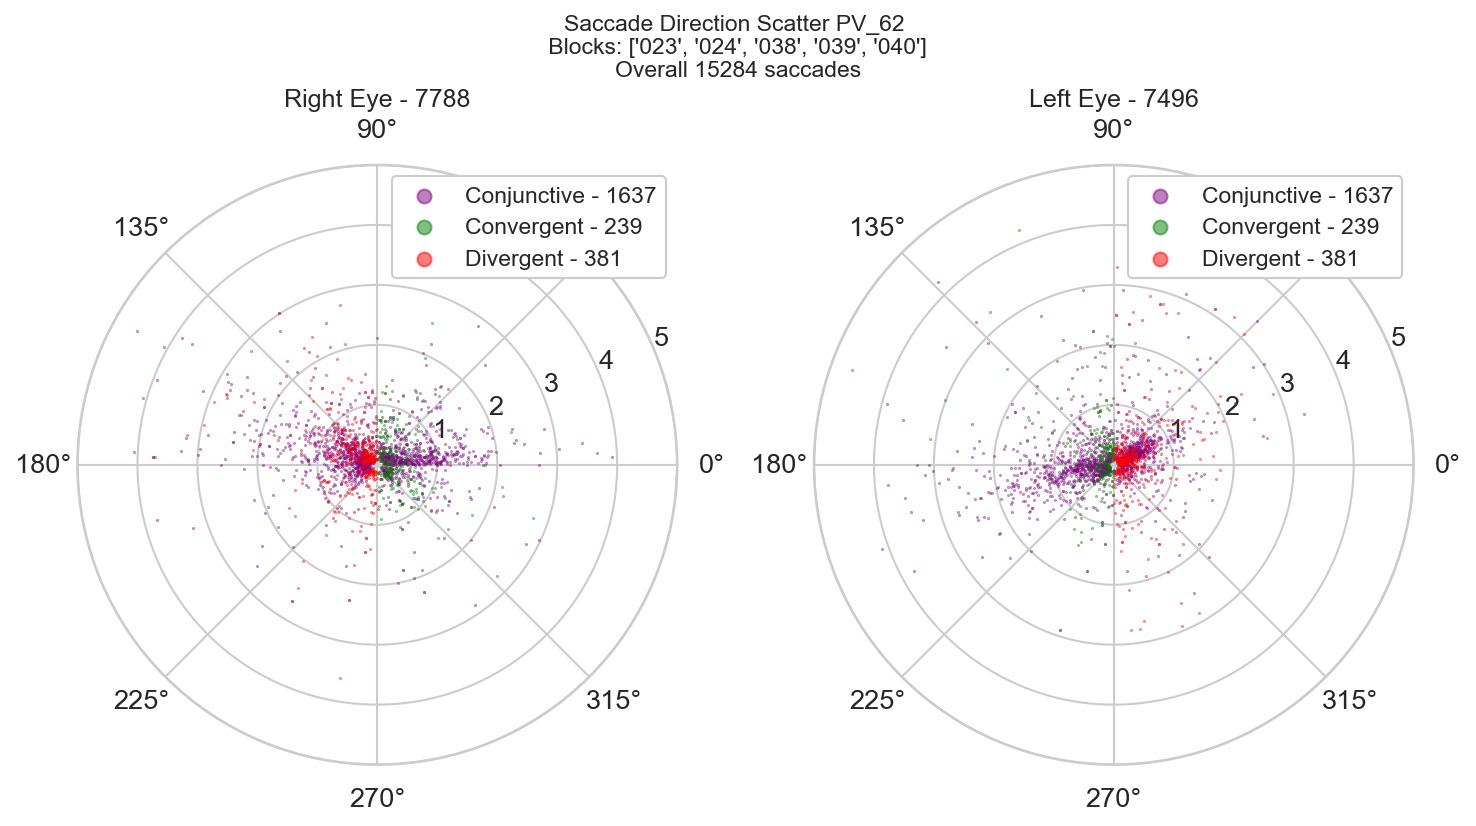

In [152]:
import matplotlib.pyplot as plt
import numpy as np

def plot_saccade_directions(synced_saccade_collection, non_synced_saccade_collection, block, block_collection, export_path=False):
    font_size = 13
    
    synced_saccades_r = synced_saccade_collection.query('eye == "R"')
    non_synced_saccades_r = non_synced_saccade_collection.query('eye == "R"')
    synced_saccades_l = synced_saccade_collection.query('eye == "L"')
    non_synced_saccades_l = non_synced_saccade_collection.query('eye == "L"')

    fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
    fig.suptitle(f'Saccade Direction Scatter {block.animal_call} \n '
                 f'Blocks: {[b.block_num for b in block_collection]} \n'
                 f'Overall {len(synced_saccades_r) + len(non_synced_saccades_r) + len(synced_saccades_l) + len(non_synced_saccades_l)} saccades', 
                 fontsize=font_size - 2, y=1)

    colors = {'conjunctive': 'purple', 'convergent': 'green', 'divergent': 'red', 'non-synced': 'blue'}

    for ax, eye, synced_saccades, non_synced_saccades in zip(axs, ['Right', 'Left'], 
                                                             [synced_saccades_r, synced_saccades_l], 
                                                             [non_synced_saccades_r, non_synced_saccades_l]):
        # ax.scatter(np.deg2rad(list(non_synced_saccades.angle.values.astype(int))),
        #            non_synced_saccades.magnitude.values,
        #            color=colors['non-synced'], 
        #            alpha=0.5, 
        #            s=0.2, 
        #            label=f'Non-Synced {len(non_synced_saccades)}')
        
        for saccade_type, color in colors.items():
            if saccade_type in synced_saccades.columns:
                ax.scatter(np.deg2rad(list(synced_saccades[synced_saccades[saccade_type] == True].angle.values.astype(int))),
                           synced_saccades[synced_saccades[saccade_type] == True].magnitude.values,
                           color=color, 
                           alpha=0.5, 
                           s=0.2, 
                           label=f'{saccade_type.capitalize()} - {len(synced_saccades[synced_saccades[saccade_type] == True].magnitude.values)}')


        ax.grid(True)
        ax.tick_params(axis='both', labelsize=font_size)
        ax.set_ylim(0, 5)
        ax.set_title(f'{eye} Eye - {len(synced_saccades) + len(non_synced_saccades)}', y=1)
        ax.legend(loc='upper right', scatterpoints=1, markerscale=15, framealpha=1)

    plt.tight_layout()
    if export_path is not False:
        plt.savefig(export_path,format='pdf')
    plt.show()
    return 

# Usage example:
block = block_collection[0]
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_scatterplot_types_noMono.pdf'
plot_saccade_directions(synced_saccade_collection, non_synced_saccade_collection, block, block_collection, export_path=export_path)


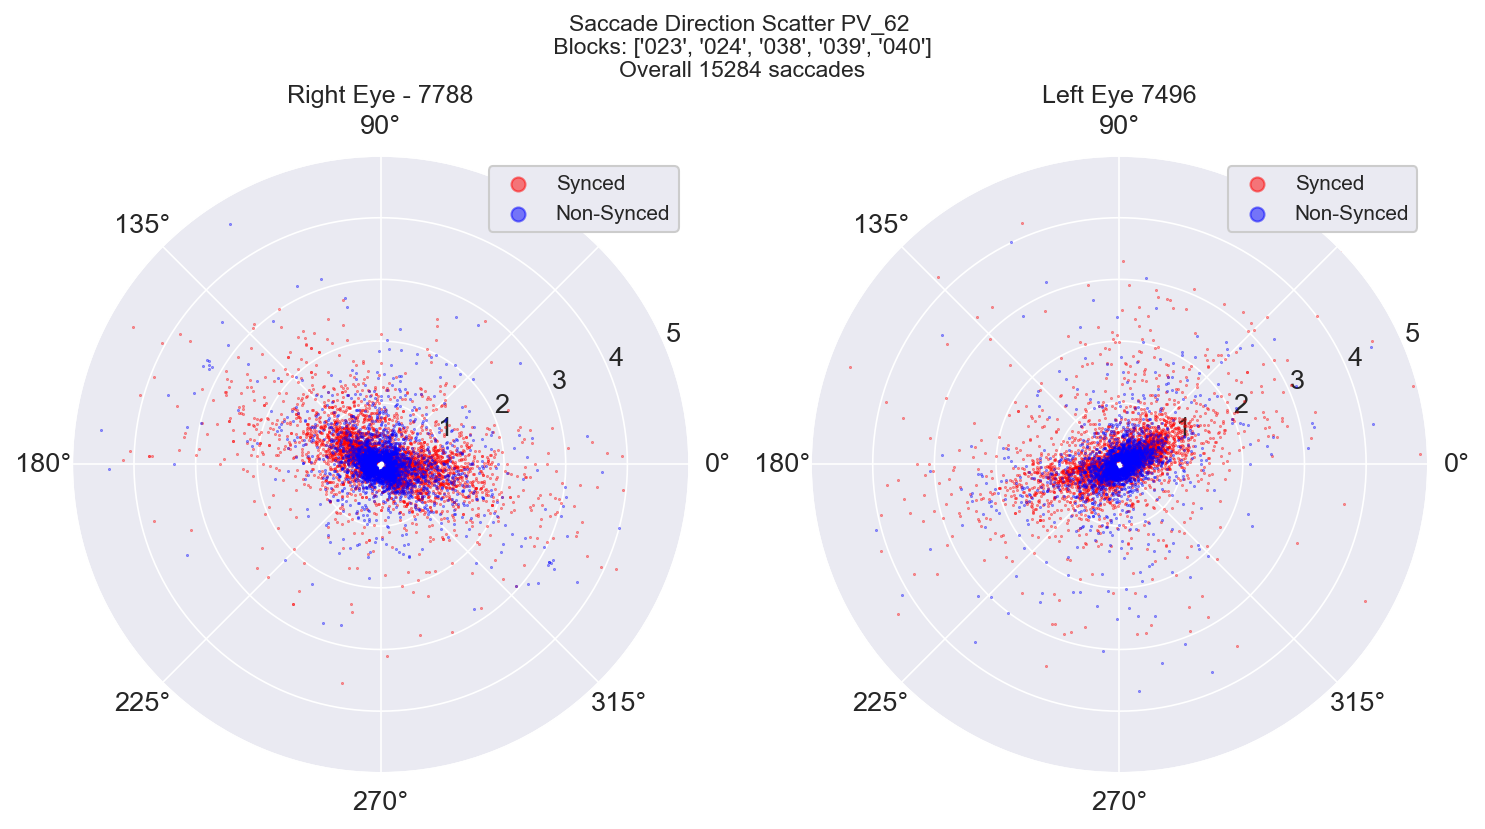

In [133]:
# Assuming you have saccade_collection and block defined somewhere in your code

font_size = 13
num_bins = 36
synced_saccades_r = synced_saccade_collection.query('eye == "R"')
non_synced_saccades_r = non_synced_saccade_collection.query('eye == "R"')
synced_saccades_l = synced_saccade_collection.query('eye == "L"')
non_synced_saccades_l = non_synced_saccade_collection.query('eye == "L"')


fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
fig.suptitle(f'Saccade Direction Scatter {block.animal_call} \n '
             f'Blocks: {[b.block_num for b in block_collection]} \n'
             f'Overall {len(synced_saccades_r) + len(non_synced_saccades_r) + len(synced_saccades_l) + len(non_synced_saccades_l)} saccades', 
             fontsize=font_size - 2, y=1)

axs[0].scatter(np.deg2rad(list(synced_saccades_r.angle.values.astype(int))), synced_saccades_r.magnitude.values, color='red', alpha=0.5, s=0.2, label='Synced')
axs[0].scatter(np.deg2rad(list(non_synced_saccades_r.angle.values.astype(int))), non_synced_saccades_r.magnitude.values, color='blue', alpha=0.5, s=0.2, label='Non-Synced')
axs[1].scatter(np.deg2rad(list(synced_saccades_l.angle.values.astype(int))), synced_saccades_l.magnitude.values, color='red', alpha=0.5, s=0.2, label='Synced')
axs[1].scatter(np.deg2rad(list(non_synced_saccades_l.angle.values.astype(int))), non_synced_saccades_l.magnitude.values, color='blue', alpha=0.5, s=0.2, label='Non-Synced')

for ax, title in zip(axs,[f'Right Eye - {len(synced_saccades_r) + len(non_synced_saccades_r)}',
                          f'Left Eye {len(synced_saccades_l) + len(non_synced_saccades_l)}']):
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=font_size)
    #ax.set_yticks([])
    ax.set_ylim(0,5)
    ax.set_title(title, y=1)
    ax.legend(loc='upper right',scatterpoints=1, markerscale=15, framealpha=1)
    #ax.set_ylabel('[mm]')

# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_scatterplot_Synced_and_non_synced.pdf', format='pdf')
plt.show()

In [109]:

def export_eyetracking_video(block, start_ms_list, end_ms_list, xflip=True, yrotate=True, rotate_frames=True, export_path=None):
    if export_path is None:
        print('No export path supplied, use a show_eye_videos')
    le_vid = block.le_videos[0]
    re_vid = block.re_videos[0]

    if len(start_ms_list) != len(end_ms_list):
        print("Error: The number of start_ms values must be equal to the number of end_ms values.")
        return
    fourcc = cv2.VideoWriter_fourcc(*'H264')
    output_video = cv2.VideoWriter(str(export_path),fourcc, 60.0, (640*2,480*2))
    le_cap = cv2.VideoCapture(le_vid)
    re_cap = cv2.VideoCapture(re_vid)

    if not le_cap.isOpened() or not re_cap.isOpened():
        print("Error opening video file.")
        return
    
    prev_l_frame = 0
    prev_r_frame = 0
    stop_flag = False
    for i, (start_ms, end_ms) in tqdm.tqdm(enumerate(zip(start_ms_list, end_ms_list))):
        if stop_flag:
            break
        if block.left_eye_data.iloc[0].ms_axis > start_ms:
            print(f'ms_axis starts at {block.left_eye_data.iloc[0].ms_axis} but {start_ms} was requested, defaulting to earliest sample')
            start_ms = block.left_eye_data.iloc[0].ms_axis
        if block.left_eye_data.iloc[-1].ms_axis < end_ms:
            print(f'ms_axis ends at {block.left_eye_data.iloc[-1].ms_axis} but {end_ms} was requested, defaulting to last sample')
            end_ms = block.left_eye_data.iloc[-1].ms_axis

        ms_timestamps = block.left_eye_data.query('ms_axis > @start_ms and ms_axis < @end_ms')['ms_axis'].values
        
        # insert a completely white frame segment of 0.5 seconds (30 frames)
        for current_ms in ms_timestamps:
            current_le_frame = int(block.left_eye_data.query('ms_axis == @current_ms').eye_frame)
            current_re_frame = int(block.right_eye_data.query('ms_axis == @current_ms').eye_frame)

            if prev_l_frame + 1 != current_le_frame:
                le_cap.set(cv2.CAP_PROP_POS_FRAMES, current_le_frame)
            l_ret, l_frame = le_cap.read()

            if prev_r_frame + 1 != current_re_frame:
                re_cap.set(cv2.CAP_PROP_POS_FRAMES, current_re_frame)
            r_ret, r_frame = re_cap.read()

            if not r_ret or not l_ret:
                break

            if xflip:
                l_frame = cv2.flip(l_frame, 1)
                r_frame = cv2.flip(r_frame, 1)
            
            if rotate_frames:
                if block.left_rotation_matrix is None or block.right_rotation_matrix is None:
                    raise AttributeError('At least one rotation matrix is missing... \n '
                                         'Run the rotate_frame_to_horizontal_with_interpolation for each eye video')
                else:
                    l_frame = cv2.warpAffine(l_frame, block.left_rotation_matrix, (l_frame.shape[1], l_frame.shape[0]))
                    r_frame = cv2.warpAffine(r_frame, block.right_rotation_matrix, (r_frame.shape[1], r_frame.shape[0]))
            # if you want to plot something on the frame, do it before rotation and rotate the annotated frame
            if yrotate:
                l_frame = cv2.rotate(l_frame, cv2.ROTATE_180)
                r_frame = cv2.rotate(r_frame, cv2.ROTATE_180)
                
            synchronized_frame = cv2.hconcat([r_frame, l_frame])
            
            # Add a black lower section to the frame
            synchronized_frame = cv2.cvtColor(synchronized_frame, cv2.COLOR_BGR2GRAY)
            
            black_section = np.zeros((l_frame.shape[0], l_frame.shape[1]*2, 3), dtype=np.uint8)
            black_section = cv2.cvtColor(black_section, cv2.COLOR_BGR2GRAY)
            
            synchronized_frame = np.vstack([synchronized_frame, black_section])
            # Write current_ms value in the added black area
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(synchronized_frame, f'Millisecond timestamp: {current_ms}', (10, l_frame.shape[0] + 30),
                        font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(synchronized_frame, f'saccade_number: {i}', (10, l_frame.shape[0] + 60),
                        font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            #print(f'frame actual size: {np.shape(synchronized_frame)}')
            output_video.write(synchronized_frame)
            prev_l_frame = current_le_frame
            prev_r_frame = current_re_frame
        # add half second white blink for saccade ends:
        if synchronized_frame is not None:
            for wb in range(5):
                output_video.write(np.ones_like(synchronized_frame)*1)
                # key = cv2.waitKey(25)
                # if key == ord('q'):
                #     stop_flag = True
                #     break
                # elif key == ord('n'):
                #     break
    output_video.release()
    le_cap.release()
    re_cap.release()
    cv2.destroyAllWindows()
    
    
clip_start = saccade_collection.query('synced_saccade==True and block == "038"').saccade_start_timestamp.values
df = block_dict['038'].left_eye_data[['OE_timestamp','ms_axis']]
clip_start_ms = np.unique(df[df.OE_timestamp.isin(clip_start)]['ms_axis'].values) - 500
clip_end_ms = np.unique(df[df.OE_timestamp.isin(clip_start)]['ms_axis'].values)+ 500
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
p = pathlib.Path(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_collection_for_test.mp4')


export_eyetracking_video(block_dict['038'], clip_start_ms[:40], clip_end_ms[:40],export_path=p)

40it [00:28,  1.39it/s]


In [16]:
# pad speed profiles for shorter saccades
# Find the maximum length
max_length = max(len(profile) for profile in saccade_collection['speed_profile'])
# Create an array filled with NaNs of the maximum length
padded_profiles = np.full((len(saccade_collection), max_length), np.nan)

# Fill in the values from each profile
for i, profile in enumerate(saccade_collection['speed_profile']):
    padded_profiles[i, :len(profile)] = profile

# Calculate the mean ignoring nan values
average_profile = np.nanmean(padded_profiles, axis=0)

# Plot individual speed profiles
fig, axs = plt.subplots(figsize=(7, 4), dpi=150)
for row in tqdm.tqdm(padded_profiles):
    axs.plot(row[:7], alpha=0.1)


# Plot average speed profile in a bolder line
axs.plot(average_profile[:7], label=f'Average Profile \n Saccade Count = {len(padded_profiles)}', linewidth=2, color='black')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.title('Speed Profiles and Average Profile')

# Show the plot
plt.show()

KeyError: 'speed_profile'

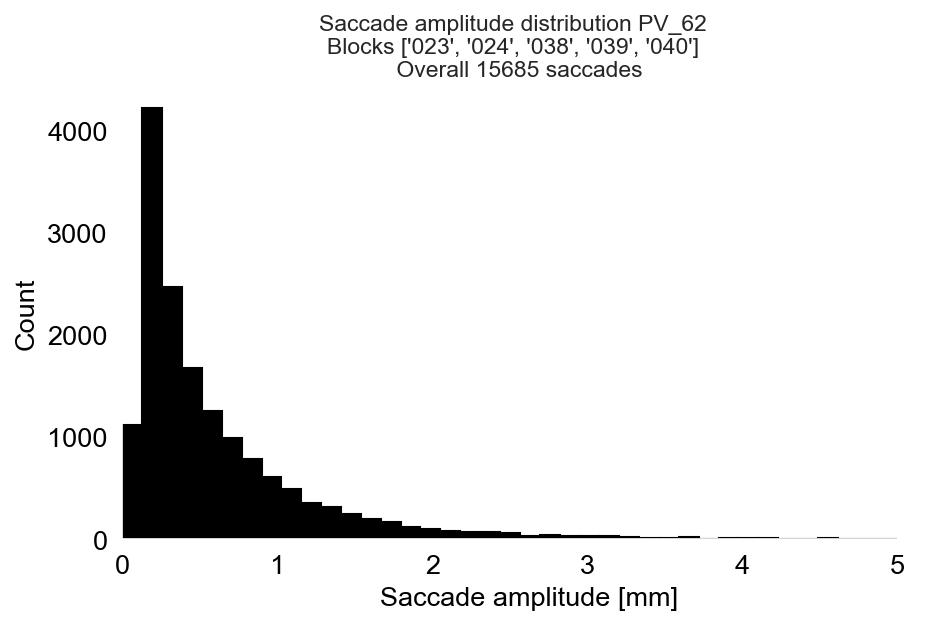

In [17]:
from scipy.stats import poisson
# make a histogram plot for all saccade magnitudes (L/R):
#all_magnitudes_mm = np.hstack([block.l_saccade_df['magnitude'].values * block.L_pix_size, block.r_saccade_df['magnitude'].values * block.R_pix_size])
all_magnitudes_mm = saccade_collection['magnitude'].values
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
ax.hist(all_magnitudes_mm,bins=np.linspace(0,5,40),log=True, color='black', edgecolor='black')

# Set title and labels
title = (f'Saccade amplitude distribution {block.animal_call} \n'
         f'Blocks {[b.block_num for b in block_collection]} \n '
         f'Overall {len(all_magnitudes_mm)} saccades')
fig.suptitle(title, fontsize=11, y=1)

ax.set_xlabel('Saccade amplitude [mm]', fontsize=13)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=13)

# Set white background and black text
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
#ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

# Set the x-axis to start precisely at 0
ax.set_xlim(left=0)
ax.tick_params(colors='black')



t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_amplitude_distribution.pdf', format='pdf')
plt.show()

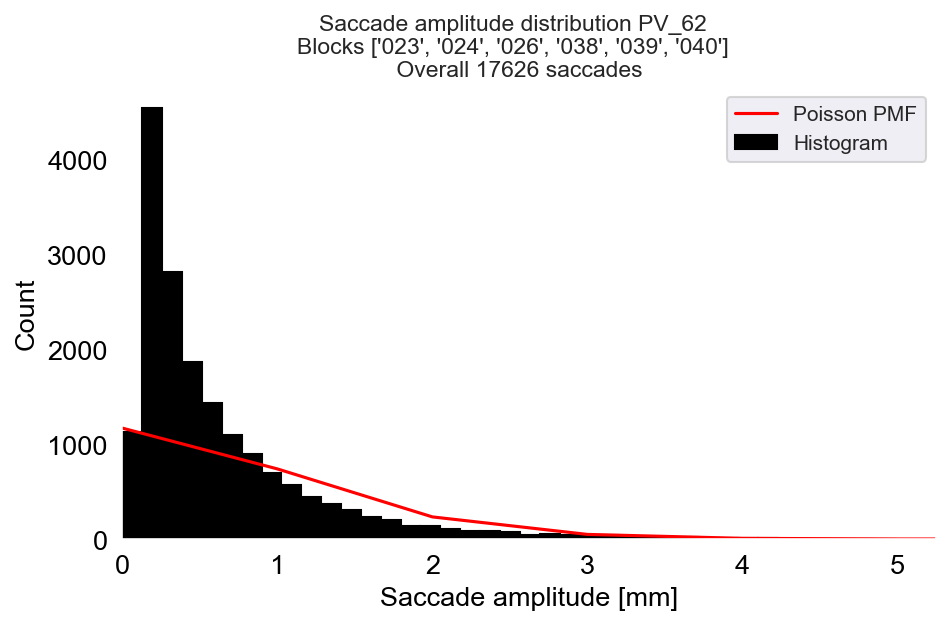

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import datetime

# Assuming you have a dataset x_values
# Replace this with your actual dataset
x_values = saccade_collection['magnitude'].values

# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
ax.hist(x_values, bins=np.linspace(0, 5, 40), log=True, color='black', edgecolor='black', label='Histogram')

# Set title and labels
title = (f'Saccade amplitude distribution {block.animal_call} \n'
         f'Blocks {[b.block_num for b in block_collection]} \n '
         f'Overall {len(x_values)} saccades')
fig.suptitle(title, fontsize=11, y=1)

ax.set_xlabel('Saccade amplitude [mm]', fontsize=13)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=13)

# Set white background and black text
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

# Set the x-axis to start precisely at 0
ax.set_xlim(left=0)
ax.tick_params(colors='black')


# Generate x values for plotting
x_plot = np.arange(0, max(x_values) + 1)

# Calculate the first four moments
x_values = all_magnitudes_mm
mu = np.mean(x_values)
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')

# Display the probability mass function (pmf)
x_plot = np.arange(0, max(x_values) + 1)
poisson_pmf = poisson.pmf(x_plot, mu)
# Calculate the PMF for each x value


# Plot the Poisson distribution pmf
ax.plot(x_plot, poisson_pmf * len(x_values) * (5 / 40), 'r-', label='Poisson PMF')

# Add legend
ax.legend()

t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
# Uncomment the line below to save the figure
# plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_amplitude_distribution.pdf', format='pdf')
plt.show()


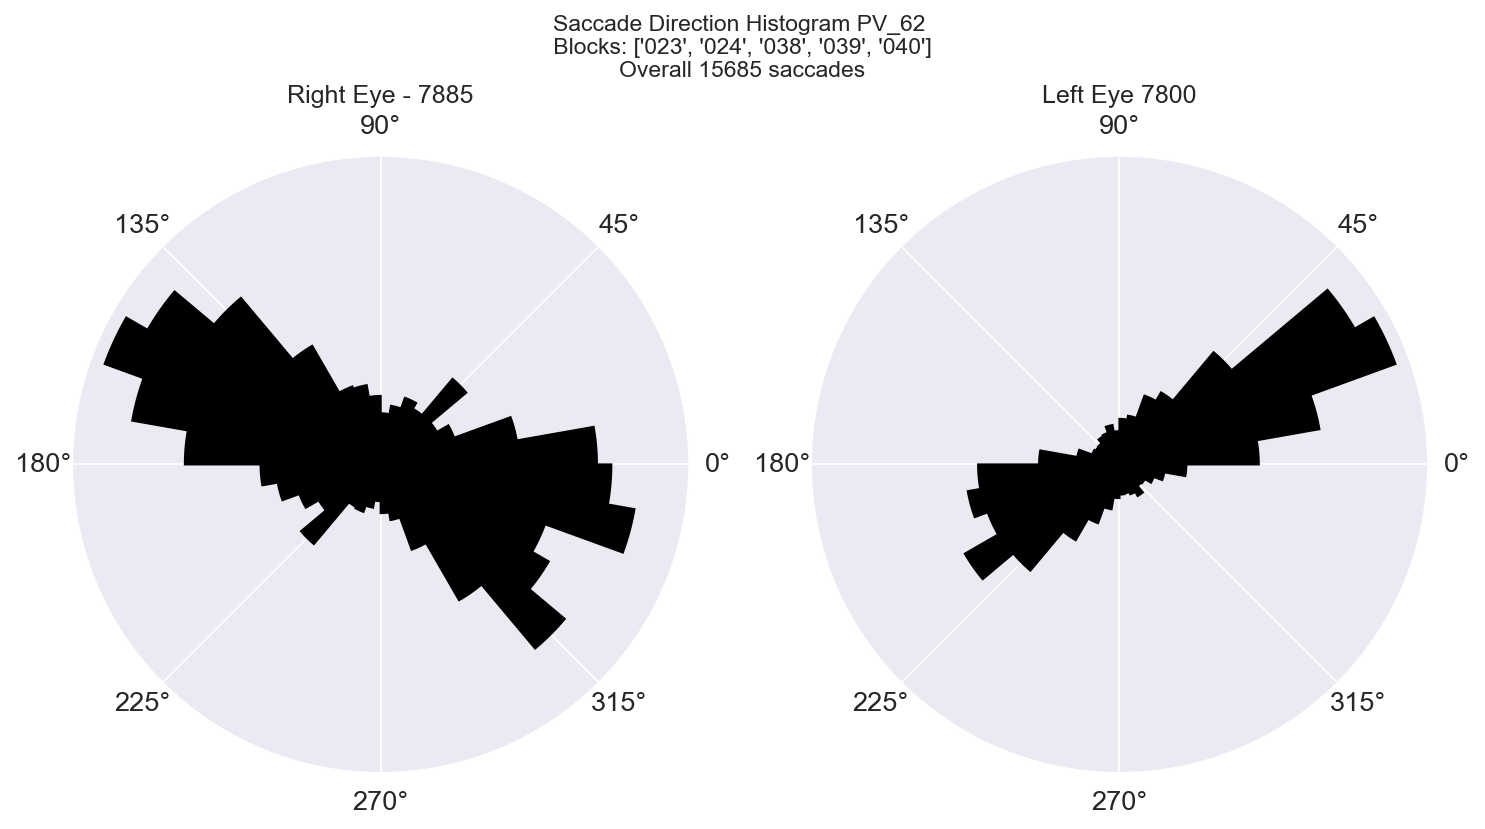

In [18]:
saccade_angles_r = saccade_collection.query('eye == "R"')['angle']
saccade_angles_l = saccade_collection.query('eye == "L"')['angle']
font_size=13
num_bins = 36
hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360))
bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2  # Calculate bin centers

hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360))
bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2  # Calculate bin centers

fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
fig.suptitle(f'Saccade Direction Histogram {block.animal_call} \n '
             f'Blocks: {[b.block_num for b in block_collection]} \n'
             f'Overall {len(saccade_collection)} saccades', fontsize=font_size-2, y=1)
fig.patch.set_facecolor('white')
# Iterate over axes objects
for ax, saccade_angles, bin_centers, title in zip(axs, [saccade_angles_r, saccade_angles_l],
                                                   [bin_centers_r, bin_centers_l],
                                                   [f'Right Eye - {len(saccade_angles_r)}', f'Left Eye {len(saccade_angles_l)}']):
    hist, _ = np.histogram(saccade_angles, bins=num_bins, range=(0, 360))
    
    # Plot the polar histogram
    ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360 / num_bins), align='center', color='black', edgecolor='black')
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=font_size)
    ax.set_yticks([])
    ax.set_title(title,y=1)
    #ax.set_facecolor('white')
# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_angles_histogram.pdf', format='pdf')
plt.show()

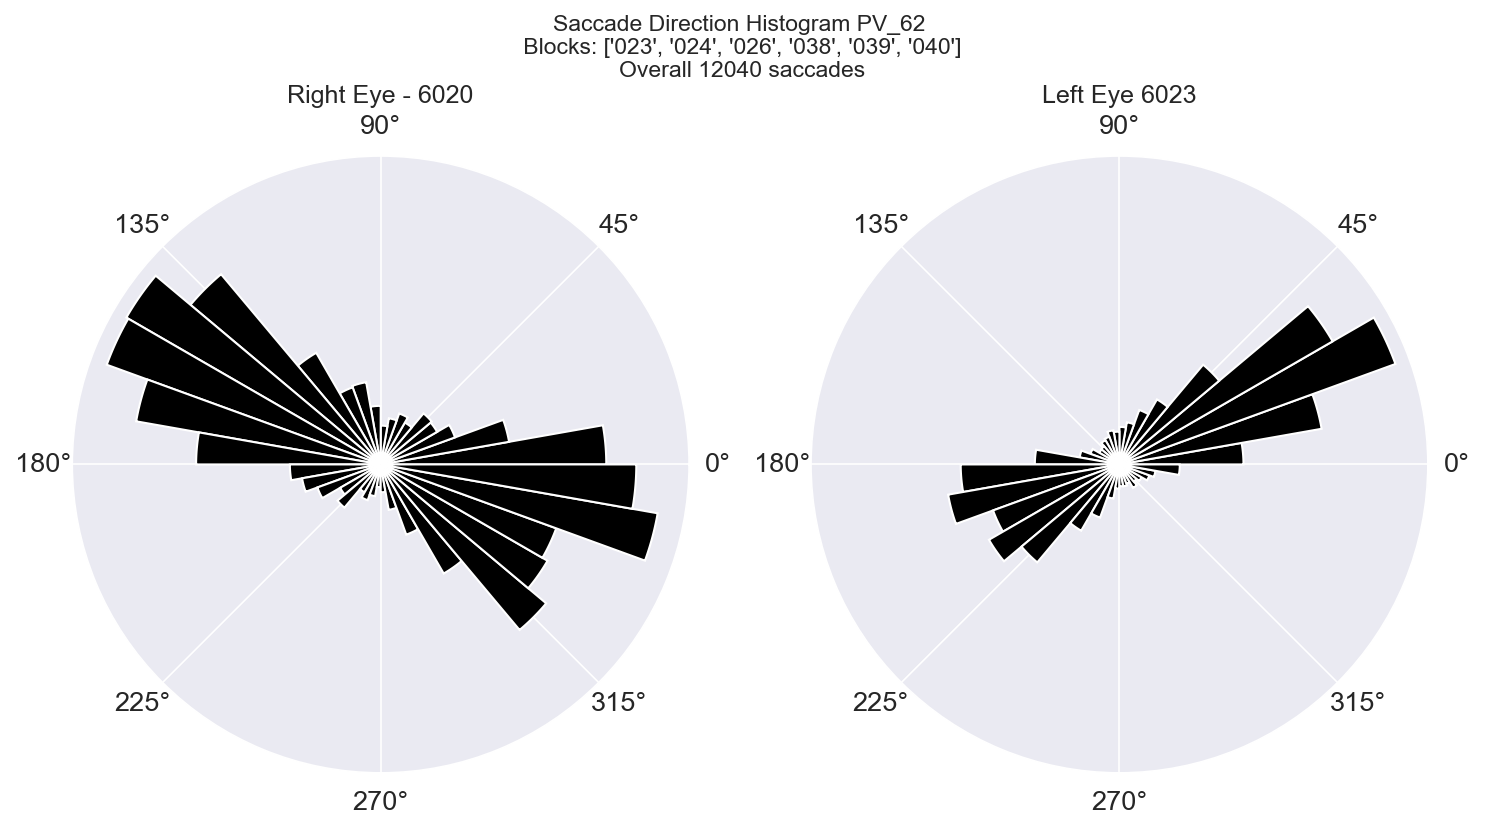

In [123]:
saccade_angles_r = saccade_collection.query('eye == "R" and synced_saccade == True')['angle']
saccade_angles_l = saccade_collection.query('eye == "L" and synced_saccade == True')['angle']
font_size=13
num_bins = 36
hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360))
bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2  # Calculate bin centers

hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360))
bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2  # Calculate bin centers

fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
fig.suptitle(f'Saccade Direction Histogram {block.animal_call} \n '
             f'Blocks: {[b.block_num for b in block_collection]} \n'
             f'Overall {len(saccade_angles_r) + len(saccade_angles_r)} saccades', fontsize=font_size-2, y=1)
# Iterate over axes objects
for ax, saccade_angles, bin_centers, title in zip(axs, [saccade_angles_r, saccade_angles_l],
                                                   [bin_centers_r, bin_centers_l],
                                                   [f'Right Eye - {len(saccade_angles_r)}', f'Left Eye {len(saccade_angles_l)}']):
    hist, _ = np.histogram(saccade_angles, bins=num_bins, range=(0, 360))
    
    # Plot the polar histogram
    ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360 / num_bins), align='center', color='black')
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=font_size)
    ax.set_yticks([])
    ax.set_title(title,y=1)
# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_angles_histogram.pdf', format='pdf')
plt.show()

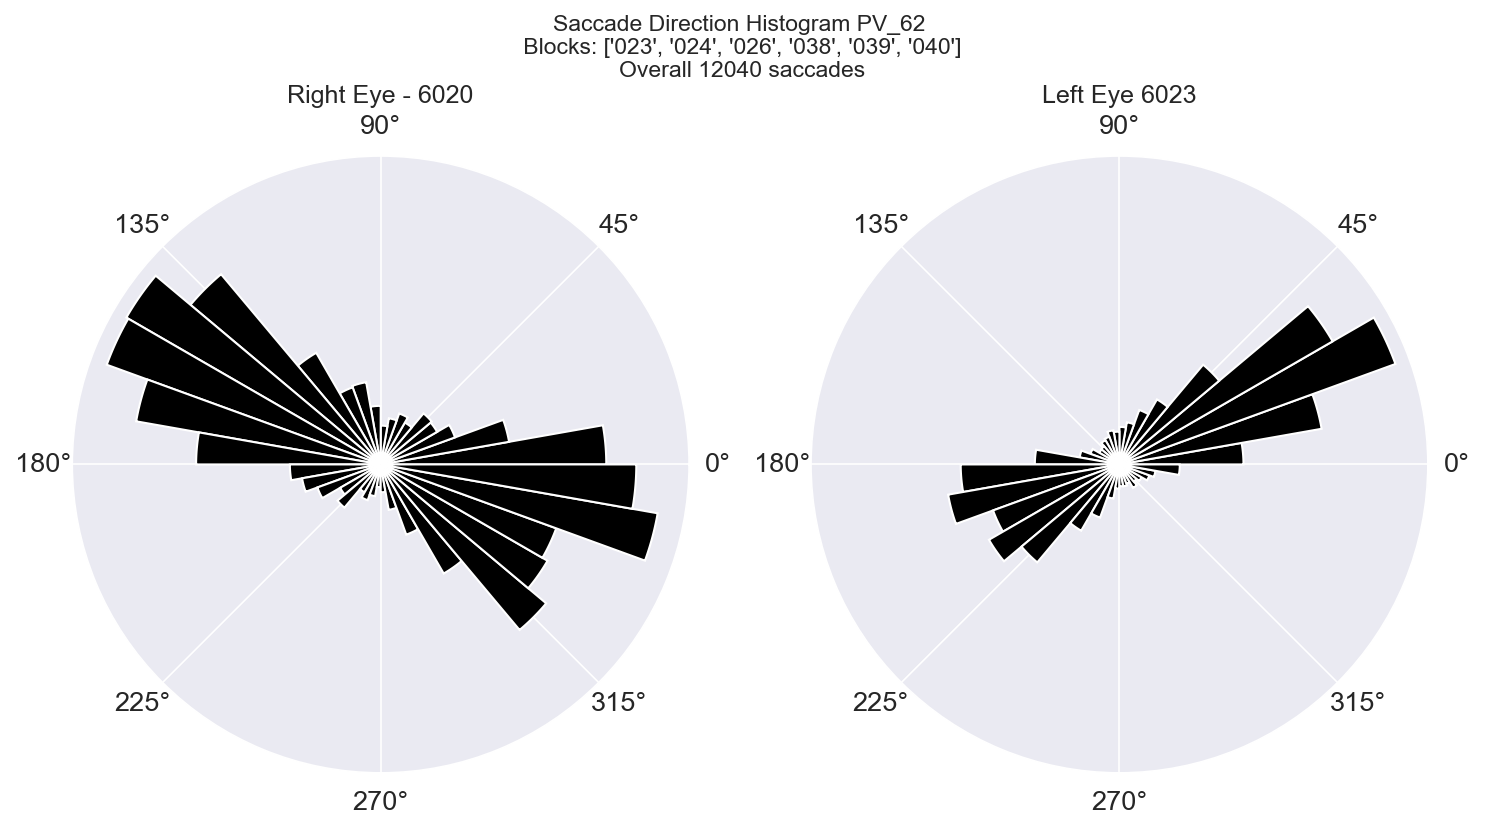

In [122]:
# Synced saccades polar scatter
saccade_angles_r = saccade_collection.query('eye == "R" and synced_saccade == True')['angle']
saccade_mags_r = saccade_collection.query('eye == "R" and synced_saccade == True')['magnitude']
saccade_angles_l = saccade_collection.query('eye == "L" and synced_saccade == True')['angle']
saccade_mags_l = saccade_collection.query('eye == "L" and synced_saccade == True')['magnitude']
font_size=13
num_bins = 36

hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360))
bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2  # Calculate bin centers

hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360))
bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2  # Calculate bin centers

fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
fig.suptitle(f'Saccade Direction Histogram {block.animal_call} \n '
             f'Blocks: {[b.block_num for b in block_collection]} \n'
             f'Overall {len(saccade_angles_r) + len(saccade_angles_r)} saccades', fontsize=font_size-2, y=1)
# Iterate over axes objects
for ax, saccade_angles, bin_centers, title in zip(axs, [saccade_angles_r, saccade_angles_l],
                                                   [bin_centers_r, bin_centers_l],
                                                   [f'Right Eye - {len(saccade_angles_r)}', f'Left Eye {len(saccade_angles_l)}']):
    hist, _ = np.histogram(saccade_angles, bins=num_bins, range=(0, 360))
    
    # Plot the polar histogram
    ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360 / num_bins), align='center', color='black')
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=font_size)
    ax.set_yticks([])
    ax.set_title(title,y=1)

# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_angles_histogram.pdf', format='pdf')
plt.show()

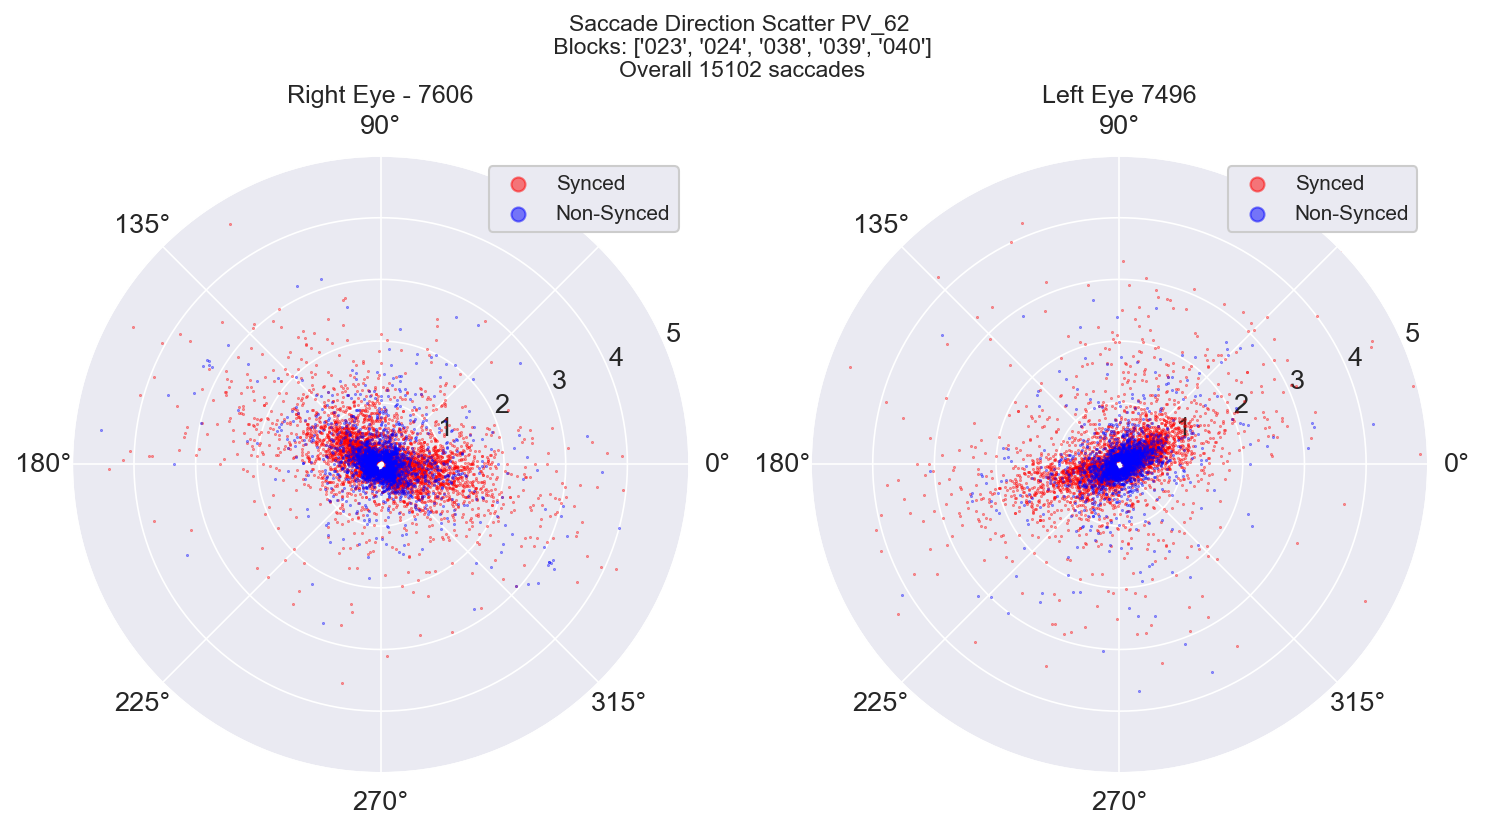

In [19]:
# Assuming you have saccade_collection and block defined somewhere in your code

font_size = 13
num_bins = 36
synced_saccades_r = saccade_collection.query('eye == "R" and synced_saccade == True').dropna()
non_synced_saccades_r = saccade_collection.query('eye == "R" and synced_saccade == False').dropna()
synced_saccades_l = saccade_collection.query('eye == "L" and synced_saccade == True').dropna()
non_synced_saccades_l = saccade_collection.query('eye == "L" and synced_saccade == False').dropna()


fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
fig.suptitle(f'Saccade Direction Scatter {block.animal_call} \n '
             f'Blocks: {[b.block_num for b in block_collection]} \n'
             f'Overall {len(synced_saccades_r) + len(non_synced_saccades_r) + len(synced_saccades_l) + len(non_synced_saccades_l)} saccades', 
             fontsize=font_size - 2, y=1)

axs[0].scatter(np.deg2rad(list(synced_saccades_r.angle.values.astype(int))), synced_saccades_r.magnitude.values, color='red', alpha=0.5, s=0.2, label='Synced')
axs[0].scatter(np.deg2rad(list(non_synced_saccades_r.angle.values.astype(int))), non_synced_saccades_r.magnitude.values, color='blue', alpha=0.5, s=0.2, label='Non-Synced')
axs[1].scatter(np.deg2rad(list(synced_saccades_l.angle.values.astype(int))), synced_saccades_l.magnitude.values, color='red', alpha=0.5, s=0.2, label='Synced')
axs[1].scatter(np.deg2rad(list(non_synced_saccades_l.angle.values.astype(int))), non_synced_saccades_l.magnitude.values, color='blue', alpha=0.5, s=0.2, label='Non-Synced')

for ax, title in zip(axs,[f'Right Eye - {len(synced_saccades_r) + len(non_synced_saccades_r)}',
                          f'Left Eye {len(synced_saccades_l) + len(non_synced_saccades_l)}']):
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=font_size)
    #ax.set_yticks([])
    ax.set_ylim(0,5)
    ax.set_title(title, y=1)
    ax.legend(loc='upper right',scatterpoints=1, markerscale=15, framealpha=1)
    #ax.set_ylabel('[mm]')

# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_scatterplot_Synced_and_non_synced.pdf', format='pdf')
plt.show()


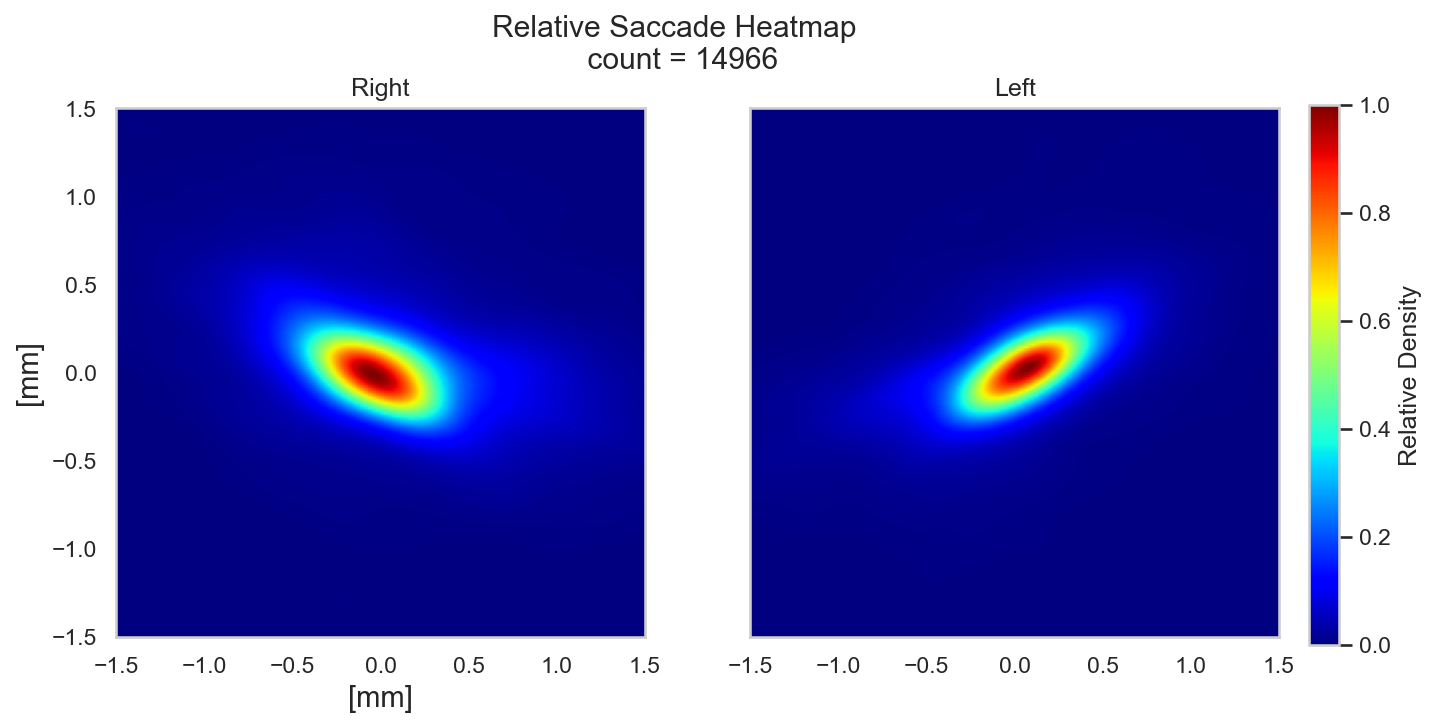

In [221]:
# Produce the all saccade heatmap
from matplotlib import colors, colorbar
saccade_df = saccade_collection.query('length < 10').dropna()

# parse queries:
l_dx = saccade_df.query('eye == "L"')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R"')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L"')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R"')['calib_dy'].dropna().values
global_max=1.5
global_min=-1.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Saccade Heatmap \n count = {len(l_dx) + len(r_dx)}', y=0.9)
sp1 = uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
sp2 = uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')

#plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_all.pdf', format='pdf')
plt.show()

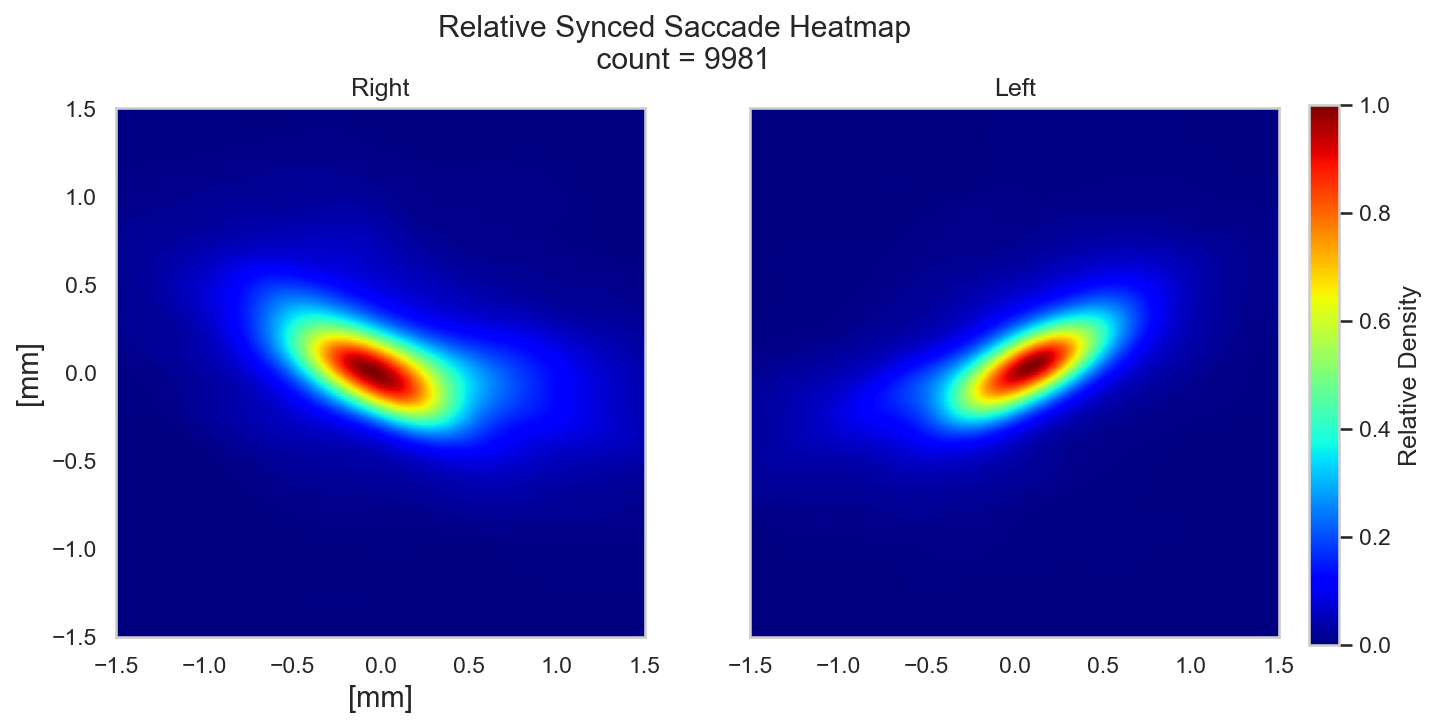

In [225]:
# Produce the synced saccade heatmap
from matplotlib import colors, colorbar
saccade_df = saccade_collection.query('length < 10').dropna()

# parse queries:
l_dx = saccade_df.query('eye == "L" and synced_saccade == True')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R" and synced_saccade == True')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L" and synced_saccade == True')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R" and synced_saccade == True')['calib_dy'].dropna().values
global_max=1.5
global_min=-1.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Synced Saccade Heatmap \n count = {len(l_dx) + len(r_dx)}', y=0.9)
sp1 = uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
sp2 = uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')

#plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_Synced.pdf', format='pdf')
plt.show()

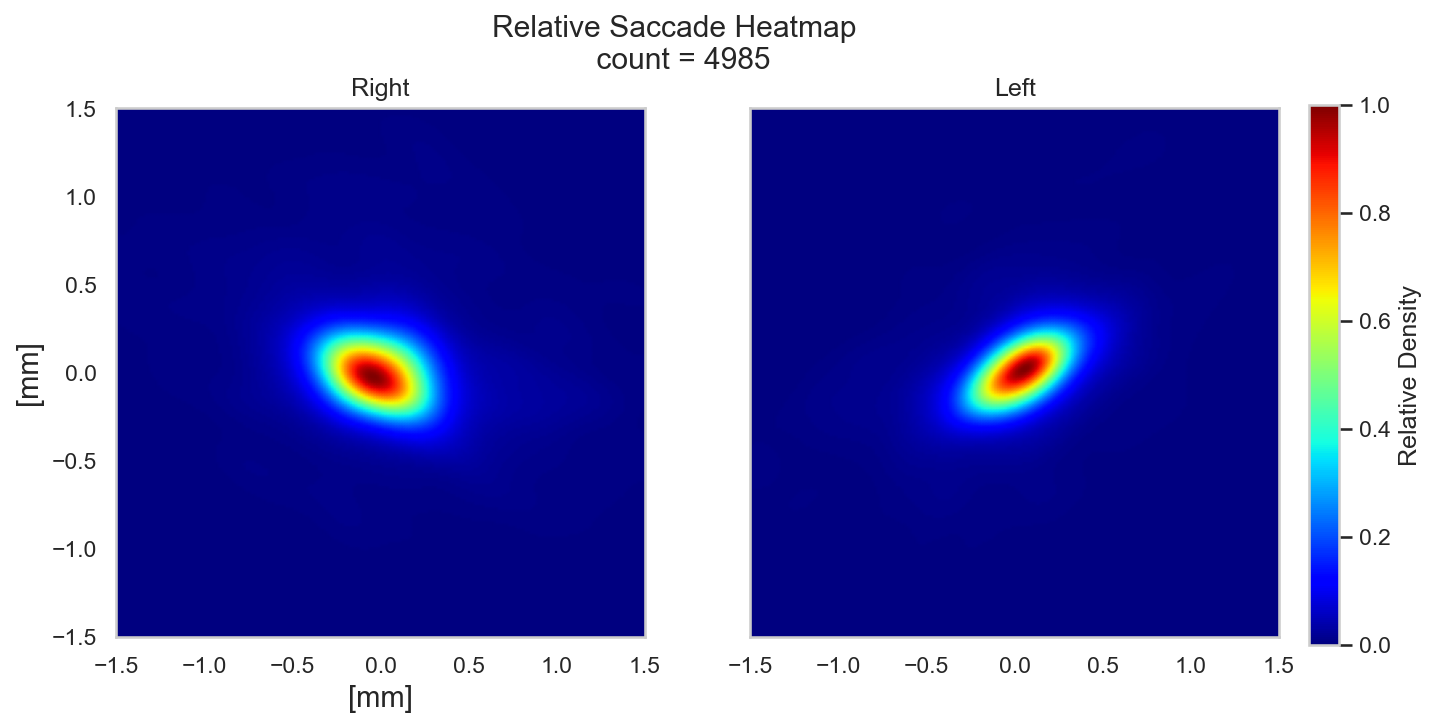

In [224]:
# Produce the non-synced saccade heatmap
from matplotlib import colors, colorbar
saccade_df = saccade_collection.query('length < 10').dropna()

# parse queries:
l_dx = saccade_df.query('eye == "L" and synced_saccade == False')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R" and synced_saccade == False')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L" and synced_saccade == False')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R" and synced_saccade == False')['calib_dy'].dropna().values
global_max=1.5
global_min=-1.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Saccade Heatmap \n count = {len(l_dx) + len(r_dx)}', y=0.9)
sp1 = uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
sp2 = uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')

#plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_non_synced.pdf', format='pdf')
plt.show()

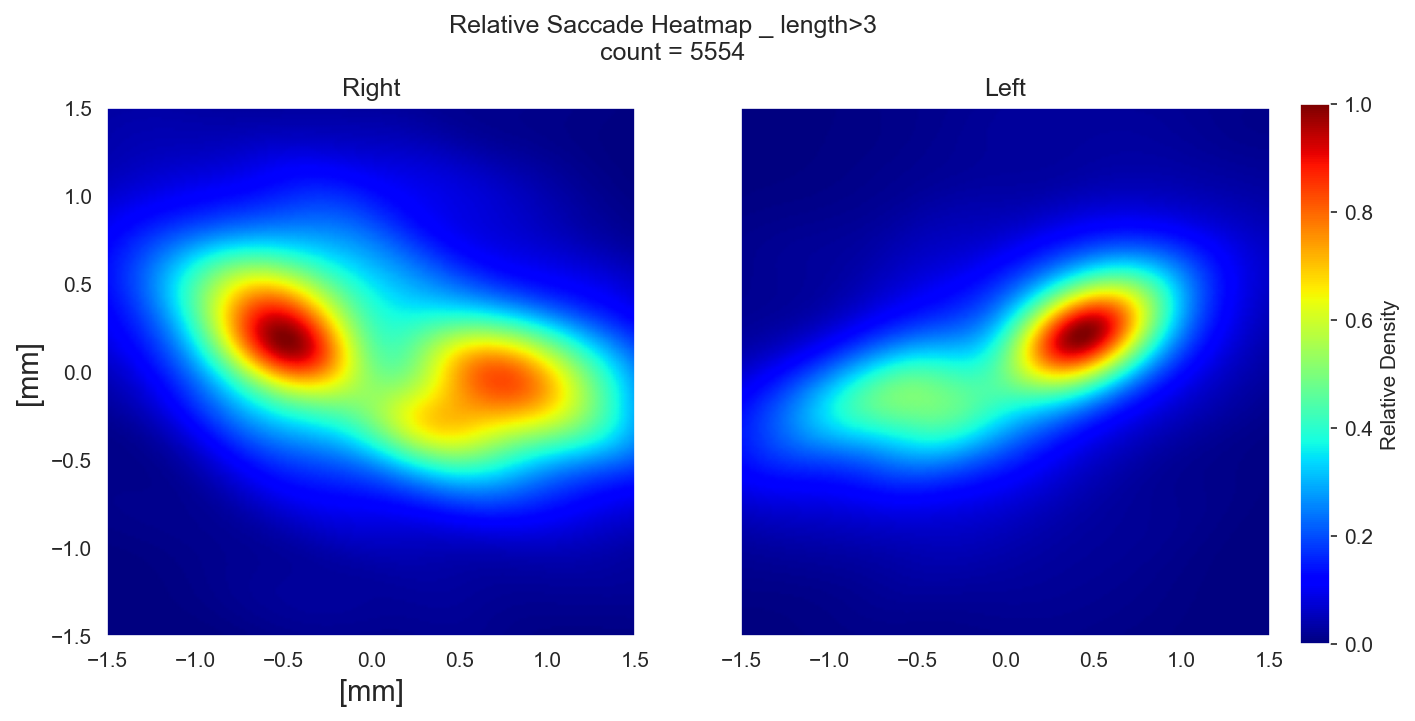

In [30]:
saccade_df = saccade_collection.query('length > 3 and length < 10').dropna()

# parse queries:
l_dx = saccade_df.query('eye == "L"')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R"')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L"')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R"')['calib_dy'].dropna().values
global_max=1.5
global_min=-1.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Saccade Heatmap _ length>3  \n count = {len(l_dx) + len(r_dx)}', y=0.9)
uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')
#plt.tight_layout()

t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_long.pdf', format='pdf')
plt.show()

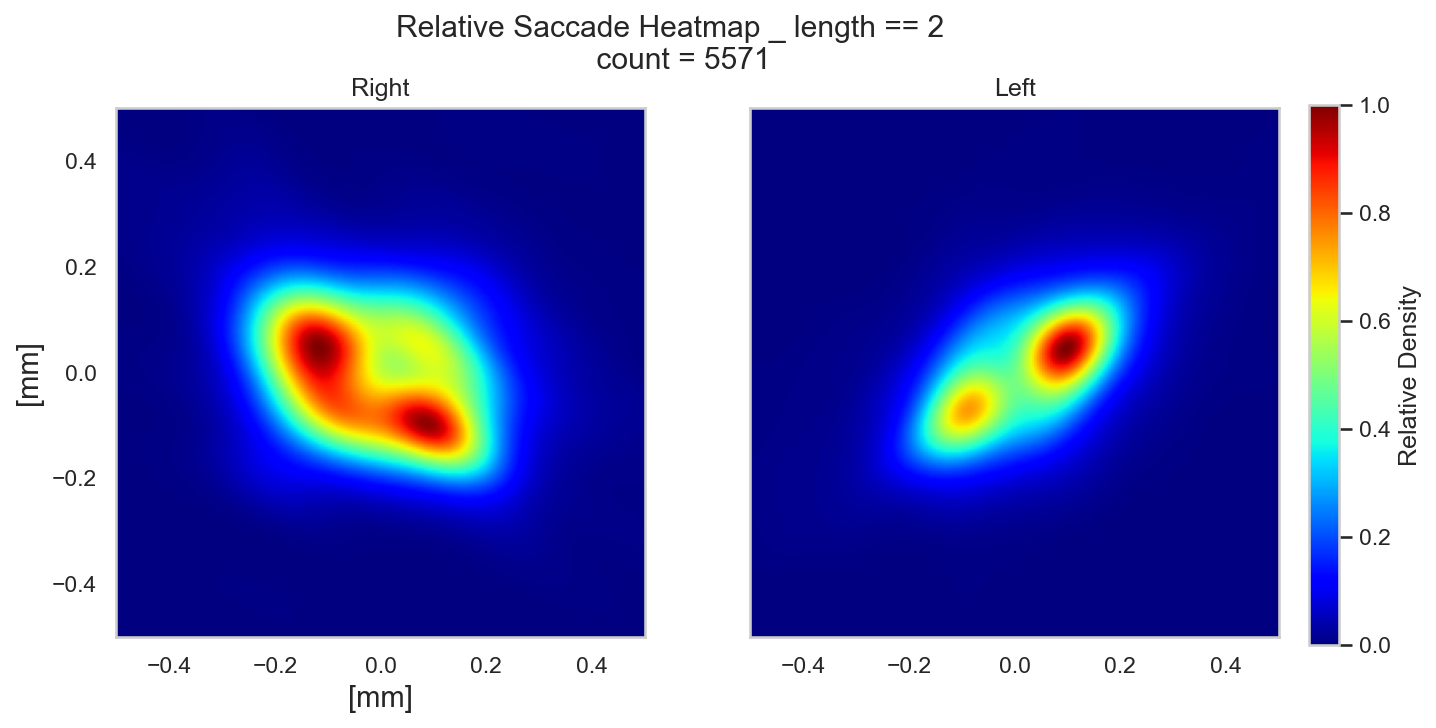

In [201]:
saccade_df = saccade_collection.query('length < 3').dropna()

# parse queries:
l_dx = saccade_df.query('eye == "L"')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R"')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L"')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R"')['calib_dy'].dropna().values
global_max=0.5
global_min=-0.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Saccade Heatmap _ length == 2  \n count = {len(l_dx) + len(r_dx)}', y=0.9)
uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')
#plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_short_adjusted_grid.pdf', format='pdf')
plt.show()

In [129]:
synced_saccades_times = saccade_collection.query('synced_saccade == True and eye == "L"').saccade_start_timestamp


In [36]:
l_times = saccade_collection.query('eye == "L" and synced_saccade=False').saccade_start_timestamp.values
r_times = saccade_collection.query('eye == "R"').saccade_start_timestamp.values


In [131]:
saccade_collection.query('synced_saccade == True and eye == "L"')

,saccade_start_ind,saccade_start_timestamp,saccade_end_ind,saccade_end_timestamp,length,magnitude,angle,initial_x,initial_y,end_x,end_y,calib_dx,calib_dy,eye,block,synced_saccade,min_diff
0,2,788260.0,7,789958.0,5,1.900819,97.615943,462.901837,271.707469,458.750908,302.751345,-0.230689,1.725272,L,023,True,17.0
2,17,793355.0,20,794374.0,3,0.603379,36.261557,456.720948,288.683031,465.415217,295.060630,0.483186,0.354437,L,023,True,0.0
3,21,794714.0,24,795733.0,3,0.391622,247.436552,465.662809,294.702316,463.134246,288.616895,-0.140526,-0.338199,L,023,True,14.0
4,44,802527.0,49,804225.0,5,0.744732,88.516298,460.858502,278.592161,461.173954,290.771144,0.017531,0.676850,L,023,True,33.0
5,57,806943.0,60,807962.0,3,0.392117,47.674037,456.119211,286.481628,460.644078,291.449867,0.251471,0.276111,L,023,True,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,193737,66400901.0,193739,66401580.0,2,1.167580,172.127525,372.820853,247.779214,334.571506,253.068022,-1.139464,0.157556,L,040,True,33.0
2007,193740,66401920.0,193744,66403278.0,4,0.371671,302.157518,335.225512,252.041645,341.214958,242.514910,0.178428,-0.283805,L,040,True,16.0
2008,193938,66469164.0,193942,66470522.0,4,0.525409,93.389249,340.354640,243.680340,339.325637,261.055500,-0.030654,0.517613,L,040,True,33.0
2010,195464,66987456.0,195468,66988814.0,4,0.260595,261.212854,376.676240,192.743963,375.415809,184.589973,-0.037549,-0.242911,L,040,True,0.0


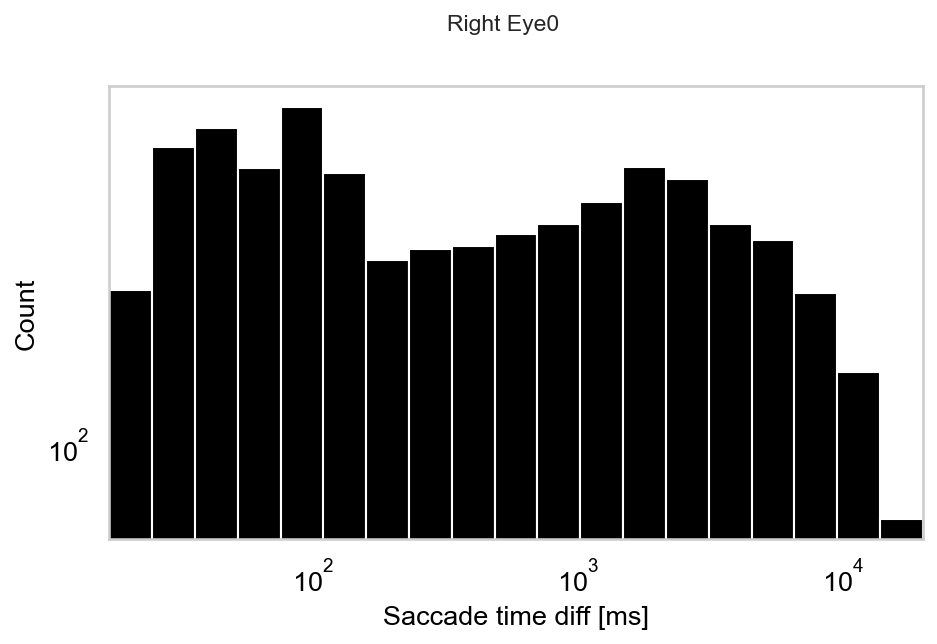

In [156]:
l_eye_saccade_diffs = (np.diff(l_times) // 340) * 17
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
bins = np.geomspace(17, 20000, 20)
ax.hist(l_eye_saccade_diffs, bins=bins, rwidth=1, log=True, color='black', edgecolor='white')

# Set title and labels
title = 'Right Eye0'
    
fig.suptitle(title, fontsize=11, y=1)
ax.set_xlabel('Saccade time diff [ms]', fontsize=13)
ax.set_xscale('log')
# ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
#ax.set_xlim(left=np.min(bins))
ax.autoscale(axis='x', tight=True)
# Set white background and black text
fig.patch.set_facecolor('white')
#ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_right_eye_saccade_intervals.pdf', format='pdf')


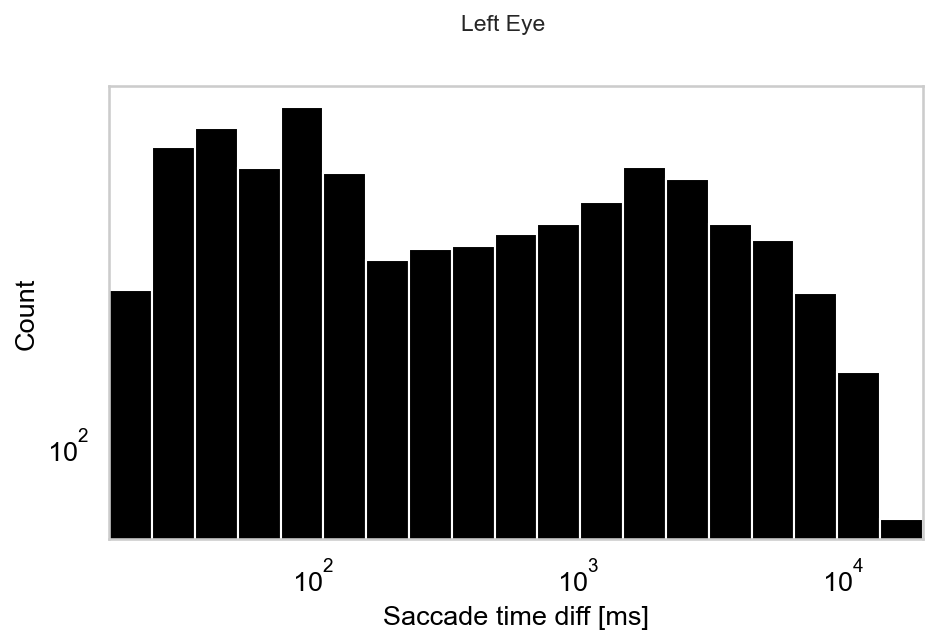

In [155]:
l_eye_saccade_diffs = (np.diff(l_times) // 340) * 17
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
bins = np.geomspace(17, 20000, 20)
ax.hist(l_eye_saccade_diffs, bins=bins, rwidth=1, log=True, color='black', edgecolor='white')

# Set title and labels
title = 'Left Eye'
    # (f'Saccade Temporal distribution {block.animal_call} \n'
    #      f'Blocks {[b.block_num for b in block_collection]} \n '
    #      f'Overall {len(l_eye_saccade_diffs)} saccades (right_eye)')
fig.suptitle(title, fontsize=11, y=1)
ax.set_xlabel('Saccade time diff [ms]', fontsize=13)
ax.set_xscale('log')
# ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
#ax.set_xlim(left=np.min(bins))
ax.autoscale(axis='x', tight=True)
# Set white background and black text
fig.patch.set_facecolor('white')
#ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_left_eye_saccade_intervals.pdf', format='pdf')


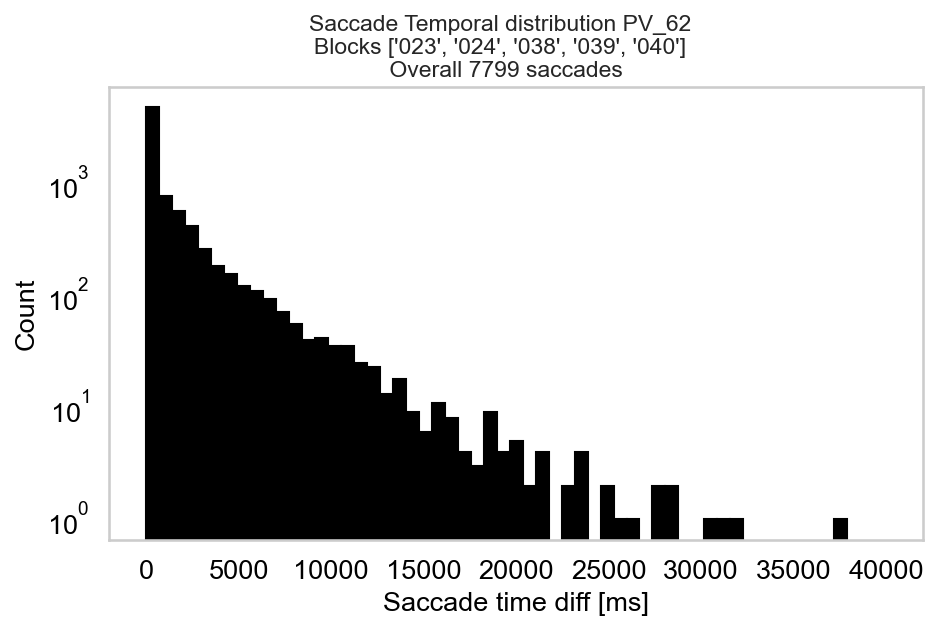

In [200]:
# make a histogram plot for all saccade magnitudes (L/R):
#all_magnitudes_mm = np.hstack([block.l_saccade_df['magnitude'].values * block.L_pix_size, block.r_saccade_df['magnitude'].values * block.R_pix_size])
l_eye_saccade_diffs = (np.diff(l_times) // 340) * 17
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
ax.hist(l_eye_saccade_diffs, bins=np.linspace(0,40000,1000 // 17),log=True, color='black', edgecolor='black')

# Set title and labels
title = (f'Saccade Temporal distribution {block.animal_call} \n'
         f'Blocks {[b.block_num for b in block_collection]} \n '
         f'Overall {len(l_eye_saccade_diffs)} saccades')
fig.suptitle(title, fontsize=11, y=1)
ax.set_xlabel('Saccade time diff [ms]', fontsize=13)
ax.set_xscale('linear')
#ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=13)

# Set white background and black text
fig.patch.set_facecolor('white')
#ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')
ax.grid(False)

In [145]:
# camera jitter report:
stop_indices_l = []
stop_indices_r = []
for block in block_collection:
    block.get_jitter_reports(export=False,overwrite=False,remove_led_blinks=False)
    rdf = pd.DataFrame.from_dict(block.re_jitter_dict)
    ldf = pd.DataFrame.from_dict(block.le_jitter_dict)
    bokeh_plotter([rdf.top_correlation_dist], ['drift_distance'])
    stop_ind_r = input('ind to stop?')
    bokeh_plotter([ldf.top_correlation_dist], ['drift_distance'])
    stop_ind_l = input('ind to stop?')
    stop_indices_l.append(stop_ind_l)
    stop_indices_r.append(stop_ind_r)
    

jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes
jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes
jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes
jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes
jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes


In [146]:
stop_arr_l = np.array(stop_indices_l).astype(int)
stop_arr_r = np.array(stop_indices_r).astype(int)

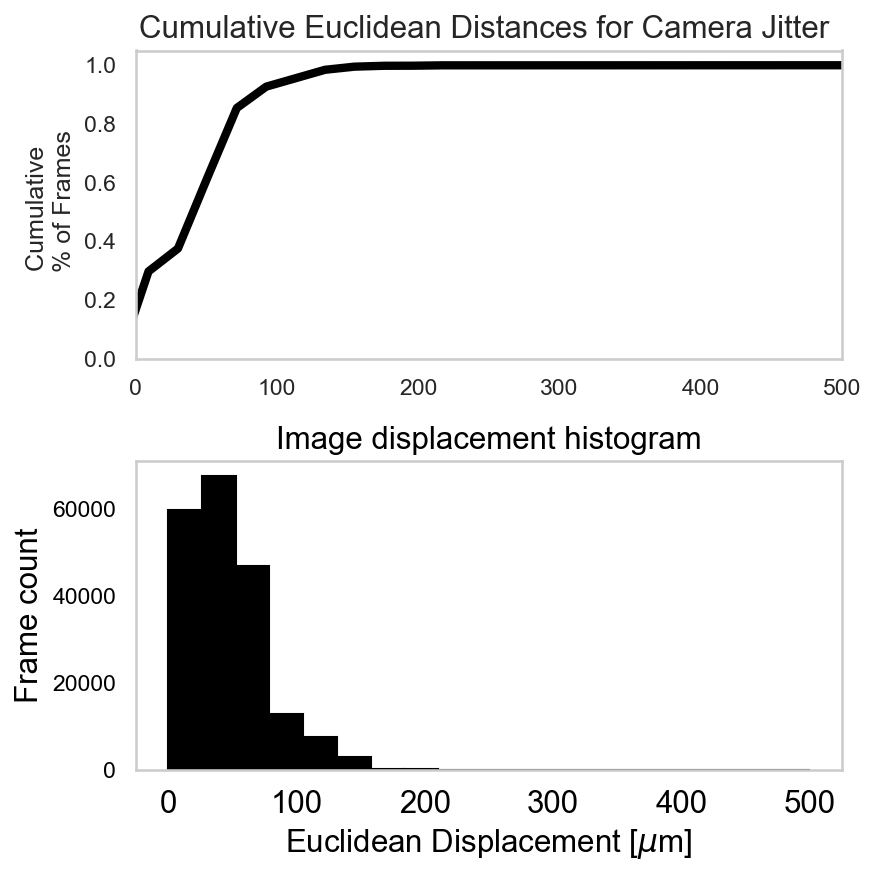

In [147]:
distances_collection = []
for i, block in enumerate(block_collection):
    # define jitter dicts
    jitter_dict_l = block.le_jitter_dict
    jitter_dict_r = block.re_jitter_dict
    
    # compute euclidean jitter magnitude
    xl = np.array(jitter_dict_l['x_displacement'])
    yl = np.array(jitter_dict_l['y_displacement'])
    l_distances = (np.sqrt(xl**2+yl**2)*block.L_pix_size*1000)[:stop_arr_l[i]]
    
    
    # compute euclidean jitter magnitude
    xr = np.array(jitter_dict_r['x_displacement'])
    yr = np.array(jitter_dict_r['y_displacement'])
    r_distances = (np.sqrt(xr**2+yr**2)*block.R_pix_size*1000)[:stop_arr_r[i]]
    
    distances_collection.append(np.concatenate([l_distances, r_distances]))

distances = np.concatenate(distances_collection)

# Create cumulative distribution plot
sns.set(style="whitegrid")
fig, axs = plt.subplots(2,figsize=(6,6),dpi=150)
#plt.suptitle(f'Cumulative Euclidean Distances for Camera Jitter')
axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter ', fontsize=15)
axs[0].set_ylabel('Cumulative \n % of Frames')
axs[0].set_xlim(0,500)
axs[0].grid(False)
#axs[0].tick_params(axis='both', which='major', labelsize=15)


# Create histogram and cumulative distribution
sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
# Calculate the ECDF
# sorted_distances = np.sort(distances)
# cumulative_percentage = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
# # Find x-value corresponding to 0.95 cumulative from ECDF
# target_cumulative = 0.95
# x_value_at_target_cumulative = np.interp(target_cumulative, cumulative_percentage, sorted_distances)
# 
# 
# # Highlight the point with a circle and add guidelines
# axs[0].scatter(x_value_at_target_cumulative, target_cumulative, color='red', marker='o', label=f'0.95 Cumulative Point')
# axs[0].axvline(x=x_value_at_target_cumulative, color='red', linestyle='--', linewidth=2)
# axs[0].axhline(y=target_cumulative, color='red', linestyle='--', linewidth=2)
# Plot the histogram
axs[1].hist(distances,bins=np.linspace(0,500,20),log=False, color='black', edgecolor='black')

# Set title and labels
title = f'Image displacement histogram'
axs[1].set_title(title, fontsize=15)
axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
axs[1].set_xscale('linear')
axs[1].set_yscale('linear')
axs[1].set_ylabel('Frame count', fontsize=15)

# Adjust tick label sizes
axs[1].tick_params(axis='x', which='major', labelsize=15)

# Set white background and black text
#fig.patch.set_facecolor('white')
axs[1].set_facecolor('white')
axs[1].title.set_color('black')
axs[1].xaxis.label.set_color('black')
axs[1].yaxis.label.set_color('black')
axs[1].tick_params(colors='black')
axs[1].grid(False)


# Display legend
#plt.legend()
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Jitter_Histogram_only_stable_stuff.pdf', format='pdf')
plt.show()

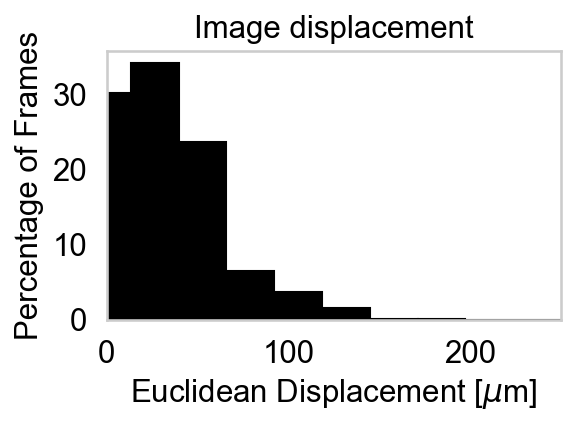

In [151]:

distances_collection = []
for i, block in enumerate(block_collection):
    # define jitter dicts
    jitter_dict_l = block.le_jitter_dict
    jitter_dict_r = block.re_jitter_dict
    
    # compute euclidean jitter magnitude
    xl = np.array(jitter_dict_l['x_displacement'])
    yl = np.array(jitter_dict_l['y_displacement'])
    l_distances = (np.sqrt(xl**2+yl**2)*block.L_pix_size*1000)[:stop_arr_l[i]]
    
    
    # compute euclidean jitter magnitude
    xr = np.array(jitter_dict_r['x_displacement'])
    yr = np.array(jitter_dict_r['y_displacement'])
    r_distances = (np.sqrt(xr**2+yr**2)*block.R_pix_size*1000)[:stop_arr_r[i]]
    
    distances_collection.append(np.concatenate([l_distances, r_distances]))

distances = np.concatenate(distances_collection)

# Create cumulative distribution plot
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, figsize=(4, 3), dpi=150)

# Plot the histogram
hist, bins = np.histogram(distances, bins=np.linspace(0, 500, 20))
percentage = (hist / len(distances)) * 100
axs.bar(bins[:-1], percentage, width=np.diff(bins), color='black', edgecolor='black')

# Set title and labels for the histogram
title = f'Image displacement'# histogram \n {len(distances)} frames ({len(distances) // 60 // 60} minutes)'
axs.set_title(title, fontsize=15)
axs.set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
axs.set_ylabel('Percentage of Frames', fontsize=15)

# Adjust tick label sizes
axs.tick_params(axis='both', which='major', labelsize=15)

# Set white background and black text
axs.set_facecolor('white')
axs.title.set_color('black')
axs.xaxis.label.set_color('black')
axs.yaxis.label.set_color('black')
axs.tick_params(colors='black')
axs.grid(False)
axs.set_xlim(0,250)

plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Jitter_Histogram_only_stable_stuff_relative.pdf', format='pdf')